# Method 2: BERT EMbeddings & FAISS Index

In [2]:
!pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 23.1 MB/s eta 0:00:00


## Load Packages

In [3]:
import numpy as np
import pandas as pd
from google.colab import drive
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader
import torch
from huggingface_hub import login
import faiss
from faiss import normalize_L2
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, f_oneway

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


## Load Data

In [5]:
file_path_1 = "/content/drive/MyDrive/QSS_45/trump_all_df_date.csv"
file_path_2 = "/content/drive/MyDrive/QSS_45/trump_events_df_date.csv"

trump_all_df_date = pd.read_csv(file_path_1)
trump_events_df_date = pd.read_csv(file_path_2)

## BERT Embeddings

In [6]:
# Convert the 'cleaned_content' column to strings and then encode
trump_all_df_date['cleaned_content'] = trump_all_df_date['cleaned_content'].astype(str)

# Similarly, for the event descriptions
trump_events_df_date['event'] = trump_events_df_date['event'].astype(str)



In [7]:
# Load pretrained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [8]:
# Function to encode a batch of texts
def encode_batch(texts, tokenizer, model, device='cuda'):
    inputs = tokenizer(texts, return_tensors='pt', truncation=True, padding=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to device
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Average pooling over token embeddings
    return embeddings.cpu().detach().numpy()  # Move back to CPU

# Batch processing for the dataframe
def batch_encode(df, column, batch_size=32, tokenizer=None, model=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    texts = df[column].tolist()
    dataloader = DataLoader(texts, batch_size=batch_size, shuffle=False)

    all_embeddings = []
    for batch in dataloader:
        embeddings = encode_batch(batch, tokenizer, model, device)
        all_embeddings.extend(embeddings)

    return all_embeddings


In [9]:
# Encode event descriptions
trump_events_df_date['event_embedding'] = batch_encode(
    trump_events_df_date, column='event', tokenizer=tokenizer, model=model)


In [10]:
trump_all_df_date['tweet_embedding'] = batch_encode(
    trump_all_df_date, column = 'cleaned_content', tokenizer=tokenizer, model=model
)

In [11]:

# Save embeddings
np.save('event_embeddings.npy', np.array(trump_events_df_date['event_embedding'].tolist()))
np.save('tweet_embeddings.npy', np.array(trump_all_df_date['tweet_embedding'].tolist()))





## Create Matches using FAISS index

In [12]:
# Load precomputed embeddings
event_embeddings = np.load("event_embeddings.npy")
tweet_embeddings = np.load("tweet_embeddings.npy")

# Assuming your DataFrames have 'date' columns for matching
event_dates = pd.to_datetime(trump_events_df_date['date'])
tweet_dates = pd.to_datetime(trump_all_df_date['date'])

# Convert embeddings to float32 (FAISS requires this)
event_embeddings = event_embeddings.astype('float32')
tweet_embeddings = tweet_embeddings.astype('float32')

# Define cosine similarity threshold
cosine_similarity_threshold = 0.98

# Helper to convert cosine similarity to FAISS L2 distance
def cosine_to_l2_threshold(cos_sim, dim):
    return 2 * (1 - cos_sim) * dim

l2_threshold = cosine_to_l2_threshold(cosine_similarity_threshold, event_embeddings.shape[1])

# Create FAISS index (IVF for faster search)
index = faiss.index_factory(event_embeddings.shape[1], "IVF100,Flat")
index.train(event_embeddings)
index.add(event_embeddings)
index.nprobe = 20  # Search 20 clusters for higher precision

# Preallocate results
matches = []

# Loop through events
for i, event_date in enumerate(event_dates):
    # Filter tweets within ±3 days
    time_window = pd.Timedelta(days=3)
    mask = (tweet_dates >= event_date - time_window) & (tweet_dates <= event_date + time_window)
    filtered_tweets = trump_all_df_date[mask]

    if not filtered_tweets.empty:
        filtered_embeddings = tweet_embeddings[mask]

        # Add embeddings to FAISS index
        index.reset()  # Clear previous data
        index.add(filtered_embeddings)

        # Query the index for nearest neighbors of the event embedding
        distances, indices = index.search(event_embeddings[i:i+1], k=len(filtered_tweets))  # Search all matches

        # Filter matches based on L2 distance threshold
        valid_indices = np.where(distances[0] <= l2_threshold)[0]

        if len(valid_indices) > 0:
            # Match event id and tweet ids
            matched_tweets = filtered_tweets.iloc[indices[0][valid_indices]]
            matches.append({
                "event_id": i,
                "event_description": trump_events_df_date.iloc[i]['event'],  # Store event description
                "event_date": event_date,
                "matched_tweet_ids": matched_tweets.index.tolist(),
                "matched_tweet_texts": matched_tweets['cleaned_content'].tolist(),  # Store tweet content
                "similarity_scores": [1 - (d / (2 * event_embeddings.shape[1])) for d in distances[0][valid_indices]]
            })
        else:
            matches.append({
                "event_id": i,
                "event_description": trump_events_df_date.iloc[i]['event'],
                "event_date": event_date,
                "matched_tweet_ids": [],
                "matched_tweet_texts": [],
                "similarity_scores": []
            })
    else:
        matches.append({
            "event_id": i,
            "event_description": trump_events_df_date.iloc[i]['event'],
            "event_date": event_date,
            "matched_tweet_ids": [],
            "matched_tweet_texts": [],
            "similarity_scores": []
        })

# Convert results to a DataFrame for better readability
results_df = pd.DataFrame(matches)
#print(results_df)


In [13]:
#results_df[["event_description", "matched_tweet_texts"]]

In [14]:
results_df.to_csv("bert_faiss_sim_scores.csv", index=False)

## Analyze & Visualizs Results

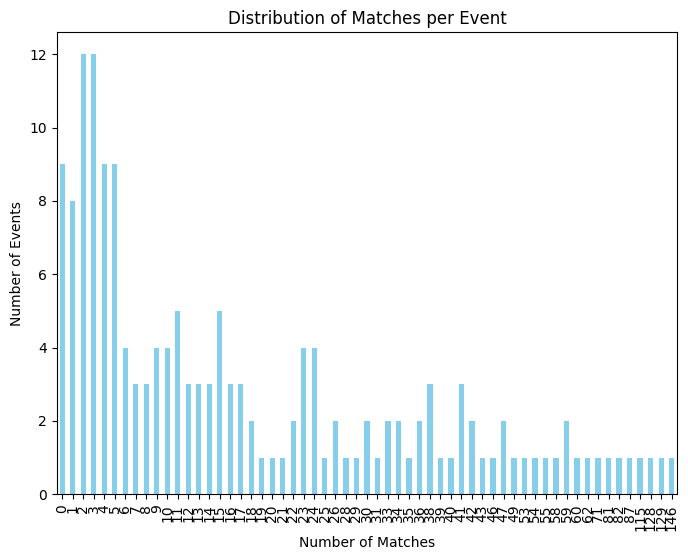

In [15]:

# Convert matches to a DataFrame for easier manipulation
matches_df = pd.DataFrame(matches)

# Create a new column to store the number of matches for each event
matches_df['num_matches'] = matches_df['matched_tweet_ids'].apply(len)

# Display the frequency of match counts (e.g., 0 matches, 1 match, 2 matches, etc.)
match_counts = matches_df['num_matches'].value_counts().sort_index()

# Plot a bar chart to visualize the distribution of match counts
plt.figure(figsize=(8, 6))
match_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Matches per Event')
plt.xlabel('Number of Matches')
plt.ylabel('Number of Events')
plt.xticks(rotation=90)
plt.show()

# Print the match counts for review
#print(match_counts)


In [16]:


# Load the approval ratings dataset


approval_df = pd.read_csv("/content/drive/MyDrive/QSS_45/adj_approval_rates_df.csv")

# Drop rows with NaN values in any column
approval_df_clean = approval_df.dropna()

# Ensure 'startdate' and 'enddate' are in datetime format
approval_df_clean['startdate'] = pd.to_datetime(approval_df_clean['startdate'])
approval_df_clean['enddate'] = pd.to_datetime(approval_df_clean['enddate'])

# Replace NaN values in 'approve' column with the mean value of the column
approval_df_clean['approve'] = approval_df_clean['approve'].fillna(approval_df_clean['approve'].mean())

# Ensure 'date' in events DataFrame is in datetime format and drop any rows with missing dates
trump_events_df_date['date'] = pd.to_datetime(trump_events_df_date['date'], errors='coerce')
trump_events_df_date = trump_events_df_date.dropna(subset=['date'])

T-statistic: -1.4916635698483864
P-value: 0.13778126672676344


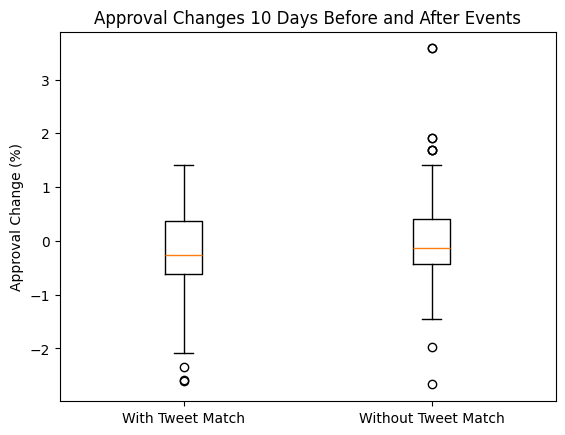

There is no significant difference in approval ratings based on tweet match.


In [17]:
# Define the time window
window_days = 10

# Function to get approval change within the time window before and after the event
def get_approval_change(event_date, approval_df, window_days):
    # Filter approval ratings before the event (10 days before)
    pre_event_df = approval_df_clean[
        (approval_df_clean['startdate'] >= event_date - pd.Timedelta(days=window_days)) &
        (approval_df_clean['startdate'] < event_date)
    ]
    pre_event = pre_event_df['approve'].mean() if not pre_event_df.empty else float('nan')

    # Filter approval ratings after the event (10 days after)
    post_event_df = approval_df_clean[
        (approval_df_clean['enddate'] > event_date) &
        (approval_df_clean['enddate'] <= event_date + pd.Timedelta(days=window_days))
    ]
    post_event = post_event_df['approve'].mean() if not post_event_df.empty else float('nan')

    return pre_event, post_event

# Preallocate lists to store results
approval_changes_with_match = []
approval_changes_without_match = []

# Loop through events and calculate approval changes based on tweet match
for _, event in trump_events_df_date.iterrows():
    event_date = event['date']
    tweet_match = event['tweet_match']  # 'Yes' or 'No'

    # Get the approval change (pre-event to post-event)
    pre_event, post_event = get_approval_change(event_date, approval_df_clean, window_days)
    if not np.isnan(pre_event) and not np.isnan(post_event):
        approval_change = post_event - pre_event

        # Append the change to the appropriate group
        if tweet_match == 'Yes':
            approval_changes_with_match.append(approval_change)
        else:
            approval_changes_without_match.append(approval_change)

# Statistical Test: Independent t-test
t_stat, p_val = ttest_ind(approval_changes_with_match, approval_changes_without_match)

# Display the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_val}")

# Plot Approval Changes
data = [approval_changes_with_match, approval_changes_without_match]
plt.boxplot(data, labels=['With Tweet Match', 'Without Tweet Match'])
plt.title('Approval Changes 10 Days Before and After Events')
plt.ylabel('Approval Change (%)')
plt.show()

# Interpretation
if p_val < 0.05:
    print("There is a statistically significant difference in approval ratings based on tweet match.")
else:
    print("There is no significant difference in approval ratings based on tweet match.")


In [18]:
# Ensure 'event_description' exists in both DataFrames
# If 'event_description' is the same as 'event', we can directly rename it
trump_events_df_date['event_description'] = trump_events_df_date['event']

# Now, merge the DataFrames
trump_events_df_date_merged = trump_events_df_date.merge(
    matches_df[['event_description', 'matched_tweet_ids']],
    on=['event_description'],
    how='left'
)


In [19]:


# Load the approval ratings dataset
approval_df = pd.read_csv("/content/drive/MyDrive/QSS_45/adj_approval_rates_df.csv")

# Drop rows with NaN values in any column
approval_df_clean = approval_df.dropna()

# Ensure 'startdate' and 'enddate' are in datetime format
approval_df_clean['startdate'] = pd.to_datetime(approval_df_clean['startdate'])
approval_df_clean['enddate'] = pd.to_datetime(approval_df_clean['enddate'])

# Replace NaN values in 'approve' column with the mean value of the column
approval_df_clean['approve'] = approval_df_clean['approve'].fillna(approval_df_clean['approve'].mean())

# Ensure 'date' in events DataFrame is in datetime format and drop any rows with missing dates
trump_events_df_date['date'] = pd.to_datetime(trump_events_df_date['date'], errors='coerce')
trump_events_df_date = trump_events_df_date.dropna(subset=['date'])


In [20]:

# Define the time window
window_days = 10

# Function to get approval change within the time window before and after the event
def get_approval_change(event_date, approval_df, window_days):
    # Filter approval ratings before the event (10 days before)
    pre_event_df = approval_df_clean[
        (approval_df_clean['startdate'] >= event_date - pd.Timedelta(days=window_days)) &
        (approval_df_clean['startdate'] < event_date)
    ]
    pre_event = pre_event_df['approve'].mean() if not pre_event_df.empty else float('nan')

    # Filter approval ratings after the event (10 days after)
    post_event_df = approval_df_clean[
        (approval_df_clean['enddate'] > event_date) &
        (approval_df_clean['enddate'] <= event_date + pd.Timedelta(days=window_days))
    ]
    post_event = post_event_df['approve'].mean() if not post_event_df.empty else float('nan')

    return pre_event, post_event

In [21]:
# Preallocate lists to store results
approval_changes_by_match_count = {0: [], 1: [], 2: [], 3: [], 4: []}

# Loop through events and calculate approval changes based on tweet match count
for _, event in trump_events_df_date_merged.iterrows():
    event_date = event['date']
    num_matches = len(event['matched_tweet_ids'])  # Number of tweet matches (0, 1, 2, 3, 4+)

    # Get the approval change (pre-event to post-event)
    pre_event, post_event = get_approval_change(event_date, approval_df_clean, window_days)
    if not np.isnan(pre_event) and not np.isnan(post_event):
        approval_change = post_event - pre_event

        # Append the change to the appropriate group based on number of matches
        if num_matches >= 4:
            approval_changes_by_match_count[4].append(approval_change)
        else:
            approval_changes_by_match_count[num_matches].append(approval_change)

F-statistic: 1.4660290328868053
P-value: 0.21516493496709327


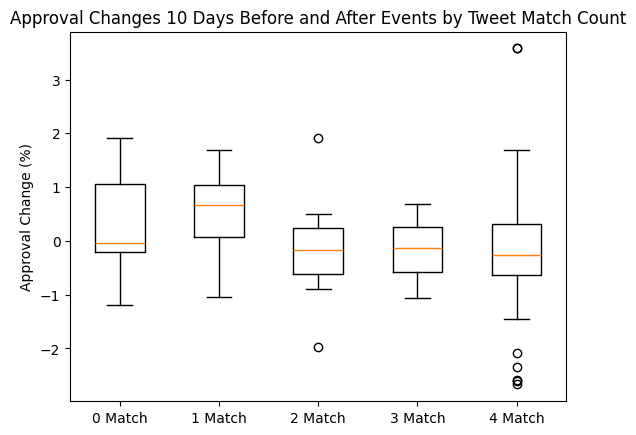

There is no significant difference in approval ratings based on tweet match count.


In [22]:
# Perform statistical test (ANOVA) to compare approval changes across different match counts
match_groups = [approval_changes_by_match_count[i] for i in range(5)]
f_stat, p_val = f_oneway(*match_groups)

# Display the results of the ANOVA

print(f"F-statistic: {f_stat}")
print(f"P-value: {p_val}")

# Box plot to visualize the approval changes for different match counts
plt.boxplot(match_groups, labels=[f'{i} Match' for i in range(5)])
plt.title('Approval Changes 10 Days Before and After Events by Tweet Match Count')
plt.ylabel('Approval Change (%)')
plt.show()

# Interpretation
if p_val < 0.05:
    print("There is a statistically significant difference in approval ratings based on tweet match count.")
else:
    print("There is no significant difference in approval ratings based on tweet match count.")
